# XGBoost trainer

This notebook function handles training and logging of xgboost models **only**, exposing both the sklearn and low level api"s.<br>
More information about XGBoost - [here](https://en.wikipedia.org/wiki/XGBoost)

Multiple model types that can be estimated using the XGBoost Scikit-Learn API. <br>
Input can either be a predefined json model configuration or one
of the five xgboost model types. <br>
In either case one can pass in a params dict to modify defaults values.<br>
Based on `mlutils.models.gen_sklearn_model`, see the function
`sklearn_classifier` in the function-marketplace repository. <br>
> **param model_type:**
  one of "classifier", "regressor",
  "ranker", "rf_classifier", or
  "rf_regressor"<br>
> **param xgb_params:** class init parameters

## Steps
1. [Data Exploration](#Data-Exploration)
2. [Importing the function](#Importing-the-function)
3. [Setup XGBoost parameters](#Setup-XGBoost-parameters)
4. [Test function locally](#Test-function-locally)
5. [Getting the model](#Getting-the-model)
6. [Some plotting](#Some-plotting)
7. [Run remotely](#Run-remotely)

### **Data Exploration**

To generate the dataset we used the "gen_class_data" function from the hub, 
which wraps scikit-learn's [make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn-datasets-make-classification).<br> 
See the link for a description of all parameters.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# make sure proper xgboost version installed, uncomment to install
# !pip install xgboost==1.3.1

In [3]:
# Getting the data from wasabi
import pandas as pd

df = pd.read_csv('https://s3.wasabisys.com/iguazio/data/function-marketplace-data/xgb_trainer/classifier-data.csv')
print(f'Data set containing {df.shape[0]} instances, with {len(df["labels"].unique())} labels.')

print(f"Number of instances labeled {df['labels'].unique()[0]} : {df.groupby('labels').count()[df.columns[0]][df['labels'].unique()[0]]}")
print(f"Number of instances labeled {df['labels'].unique()[1]} : {df.groupby('labels').count()[df.columns[0]][df['labels'].unique()[1]]}")

df.head()

Data set containing 10000 instances, with 2 labels.
Number of instances labeled 1 : 5008
Number of instances labeled 0 : 4992


,feat_0,feat_1,feat_2,feat_3,feat_4,labels
0,-0.265115,-1.932260,0.303992,-1.863833,-1.045635,1
1,-3.135479,-2.835548,1.338381,-1.385303,-2.276456,0
2,-1.519005,-1.807549,0.697304,-1.118860,1.104900,0
3,-0.632087,-0.345659,0.244329,-0.046066,0.447280,0
4,-1.405883,-1.746045,0.653617,-1.110985,-1.675466,0


### **Importing the function**

In [4]:
from mlrun import import_function
from mlrun.platforms.other import auto_mount

# If GPU is available - set to True
GPU = False


fn = import_function("hub://xgb_trainer")
fn.image = "mlrun/ml-models" if not GPU else "mlrun/ml-models-gpu"
fn.apply(auto_mount())

### **Setup XGBoost parameters**

In [5]:
task_params = {"model_type": "classifier",
               "CLASS_tree_method": "hist",
               "CLASS_objective": "binary:logistic",
               "CLASS_booster": "gbtree",
               "FIT_verbose": 0,
               "label_column": "labels"}

### **Test function locally**

> 2021-10-13 09:12:10,154 [info] starting run xgb-trainer-train_model uid=a4d1167f89324ebeb906cb9d13270be7 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...13270be7,0,Oct 13 09:12:10,completed,xgb-trainer-train_model,v3io_user=danikind=owner=danihost=jupyter-dani-5bbd9959b7-tsgh8,dataset,model_type=classifierCLASS_tree_method=histCLASS_objective=binary:logisticCLASS_booster=gbtreeFIT_verbose=0label_column=labels,accuracy=0.9552test-error=0.0448rocauc=0.9799618829687036brier_score=0.038984999293145965f1-score=0.954983922829582precision_score=0.965679190751445recall_score=0.9445229681978798,test_setprobability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarymodel


> 2021-10-13 09:12:12,393 [info] run executed, status=completed


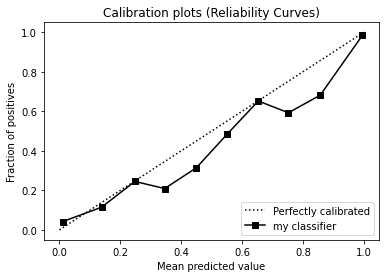

<Figure size 432x288 with 0 Axes>

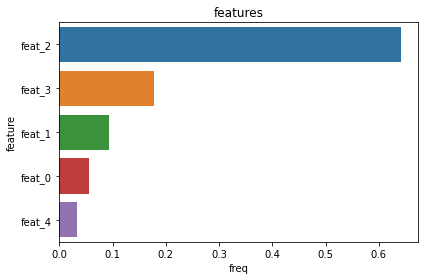

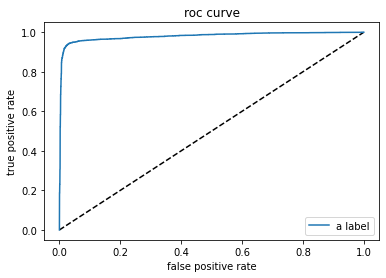

In [6]:
train_run = fn.run(params = task_params,    
                   inputs={"dataset"  : 'https://s3.wasabisys.com/iguazio/data/function-marketplace-data/xgb_trainer/classifier-data.csv'},
                   local=True)

### **Getting the model**

In [7]:
from mlrun.artifacts import get_model
import pickle

model_file, model_obj, _ = get_model(train_run.artifact('model'))
model = pickle.load(open(model_file,'rb'))

In [8]:
print(f"model score : {model.score(train_run.artifact('test_set').as_df().drop(['labels'],axis=1),train_run.artifact('test_set').as_df()['labels'])}")

model score : 0.9632


### **Some plotting**

#### Display the probability calibration


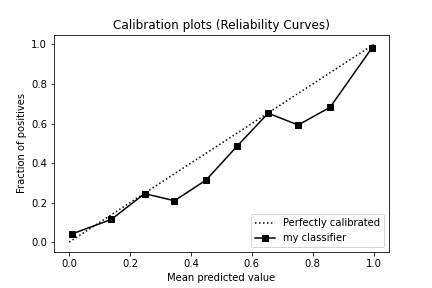

In [9]:
train_run.artifact('probability-calibration').show()


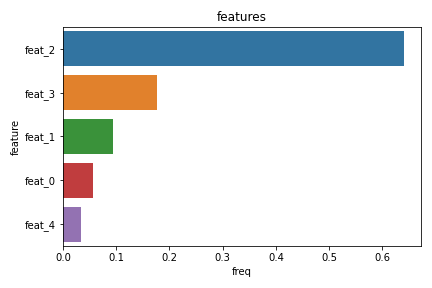

In [10]:
train_run.artifact('feature-importances').show()

### **Run remotely**

In [11]:
fn.spec.build.commands=['pip install xgboost==1.3.1']
fn.deploy(with_mlrun=False)

> 2021-10-13 09:12:13,048 [info] Started building image: .mlrun/func-default-xgb-trainer:latest
INFO[0000] Retrieving image manifest mlrun/mlrun:0.7.1  
INFO[0000] Retrieving image manifest mlrun/mlrun:0.7.1  
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Retrieving image manifest mlrun/mlrun:0.7.1  
INFO[0000] Retrieving image manifest mlrun/mlrun:0.7.1  
INFO[0001] Executing 0 build triggers                   
INFO[0001] Unpacking rootfs as cmd RUN pip install xgboost==1.3.1 requires it. 
INFO[0015] RUN pip install xgboost==1.3.1               
INFO[0015] Taking snapshot of full filesystem...        
INFO[0026] cmd: /bin/sh                                 
INFO[0026] args: [-c pip install xgboost==1.3.1]        
INFO[0026] Running: [/bin/sh -c pip install xgboost==1.3.1] 
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
INFO[0032] Taking snapshot of full filesystem...        


True

In [12]:
fn.run(inputs={"dataset"  : 'https://s3.wasabisys.com/iguazio/data/function-marketplace-data/xgb_trainer/classifier-data.csv'},
       params=task_params)

> 2021-10-13 09:13:17,645 [info] starting run xgb-trainer-train_model uid=5a8f100ed417473fad50e7b8bde69e7c DB=http://mlrun-api:8080
> 2021-10-13 09:13:17,825 [info] Job is running in the background, pod: xgb-trainer-train-model-wwmmr
> 2021-10-13 09:13:32,738 [info] run executed, status=completed
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...bde69e7c,0,Oct 13 09:13:29,completed,xgb-trainer-train_model,v3io_user=danikind=jobowner=danihost=xgb-trainer-train-model-wwmmr,dataset,model_type=classifierCLASS_tree_method=histCLASS_objective=binary:logisticCLASS_booster=gbtreeFIT_verbose=0label_column=labels,accuracy=0.9552test-error=0.0448rocauc=0.9799618829687036brier_score=0.038984999293145965f1-score=0.954983922829582precision_score=0.965679190751445recall_score=0.9445229681978798,test_setprobability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarymodel


> 2021-10-13 09:13:37,037 [info] run executed, status=completed


[Back to the top](#XGBoost-trainer)